In [7]:
import numpy as np

# import tensorflow as tf
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.ops.nn import max_pool2d, depthwise_conv2d
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.activations import relu
from tensorflow import function as tf_function, cos, sin, stack, repeat, shape, cast, float32, random
from tensorflow import zeros_initializer, zeros
from matplotlib import pyplot as plt

In [39]:


CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5


class CAModel(Model):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = Sequential([
          Conv2D(128, 1, activation=relu),
          Conv2D(self.channel_n, 1, activation=None, kernel_initializer=random.uniform),
    ])

    self(zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  def get_living_mask(self, x):
    alpha = x[:, :, :, 3:4]
    return max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1


  @tf_function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = cos(angle), sin(angle)
    kernel = stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = repeat(kernel, self.channel_n, 2)

    y = depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf_function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = self.get_living_mask(x)

    y = self.perceive(x, angle)
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = random.uniform(shape(x[:, :, :, :1])) <= fire_rate
    x += dx * cast(update_mask, float32)

    post_life_mask = self.get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    return x * cast(life_mask, float32)


CAModel().dmodel.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (1, 3, 3, 128)            6272      
_________________________________________________________________
conv2d_53 (Conv2D)           (1, 3, 3, 16)             2064      
Total params: 8,336
Trainable params: 8,336
Non-trainable params: 0
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


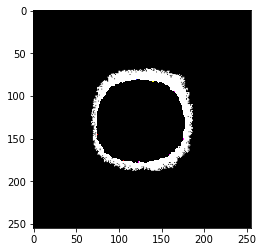

In [47]:
model = CAModel()

state = np.float32(np.zeros(shape=(1, 255, 255, CHANNEL_N)))
state[0, 128, 128, :] = 1.0

plt.imshow(state[0, :, :, :3])
for i in range(60):
    state = model(state)

plt.imshow(state[0, :, :, :3])